In [14]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import math
from functools import partial
from open3d.t.geometry import TriangleMesh
import util

In [ ]:
dataname = "C:/Users/chris/Desktop/Documents/NewData/CircularVentilationGrateExtraCleanedFull.ply"
pcd = o3d.io.read_point_cloud(dataname)
pcd = util.preProcessCloud(pcd)

In [16]:
def colorize_octree(octree, depth=8):
    colors = np.random.rand(2**depth, 3)  # Generate random colors for nodes

    def assign_color(node, node_info):
        if node_info.depth == depth:
            node.color = colors[node_info.child_index]  # Assign a color to each leaf node

    octree.traverse(assign_color)

# Define the octree depth
octree_depth = 8  # Higher depth = more subdivisions

# Create an octree and convert the point cloud into it
octree = o3d.geometry.Octree(max_depth=octree_depth)
octree.convert_from_point_cloud(pcd, size_expand=0.01)  # Expand slightly to ensure full coverage

# colorize_octree(octree, depth=octree_depth)
o3d.visualization.draw_geometries([octree])


In [17]:
def calculate_eigen_norm_and_plane_direction(neighbor_coordinates):
    if len(neighbor_coordinates) < 3:
        return np.array([0, 0, 0]), np.array([0, 0, 0]), np.array([0, 0, 0])
    
    mu = np.mean(neighbor_coordinates, axis=0)
    norm = neighbor_coordinates - mu
    cov = np.cov(norm.T)
    eig_val, eig_vec = np.linalg.eig(cov)
    sorted_idx = np.argsort(eig_val)[::-1]
    eig_val = eig_val[sorted_idx]
    eig_vec = eig_vec[:, sorted_idx]
    eig_val_norm = eig_val.copy()

    for z in range(len(eig_val)):
        eig_val_norm[z] = np.exp(eig_val[z])/np.sum(np.exp(eig_val))

    plane_direction = np.cross(eig_vec[:, 0], eig_vec[:, 1])

    return mu, eig_val_norm, plane_direction

In [18]:
import colorsys
import numpy as np

def plane_direction_to_color_hue_based(plane_direction, hue_contrast=0.5):
    """ Convert a plane normal (x, y, z) into an RGB color with enhanced hue contrast. """
    # Normalize direction vector
    plane_direction = plane_direction / np.linalg.norm(plane_direction)

    # Ensure flipped vectors get the same color by taking absolute values
    r = abs(plane_direction[0])
    g = abs(plane_direction[1])
    b = abs(plane_direction[2])

    # Convert to HSV
    hue, saturation, value = colorsys.rgb_to_hsv(r, g, b)

    # **Enhance hue contrast** (scale it non-linearly)
    hue = hue**hue_contrast  # Non-linear scaling to make colors sharper

    # Convert back to RGB
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)

    return [r, g, b]  # RGB values naturally in range [0,1]

def plane_direction_to_color(plane_direction, contrast_factor=0.5):
    """ Convert a plane normal (x, y, z) into a high-contrast RGB gradient mapping. """
    # Normalize direction vector
    plane_direction = plane_direction / np.linalg.norm(plane_direction)

    # Ensure flipped vectors get the same color by taking absolute values
    r = abs(plane_direction[0])
    g = abs(plane_direction[1])
    b = abs(plane_direction[2])

    # **Enhance contrast using exponential scaling**
    r = r**contrast_factor
    g = g**contrast_factor
    b = b**contrast_factor

    return [r, g, b]  # RGB values naturally in range [0,1]

def apply_pca_to_tree(pcd, octree, depth=8, vector_scale=0.6, min_points=5):
    lines = []
    colors = []
    all_points = np.asarray(pcd.points)
    def apply_pca(node, node_info):
        if node_info.depth == depth and isinstance(node, o3d.geometry.OctreeLeafNode):
            #print('Hi')
            if hasattr(node, "indices"):
                leaf_points = all_points[node.indices]

                if len(leaf_points) < min_points:
                    return
                
                mu, _, plane_direction = calculate_eigen_norm_and_plane_direction(leaf_points)
                # Compute start and end points of the line
                start_point = mu - (vector_scale / 2) * plane_direction
                end_point = mu + (vector_scale / 2) * plane_direction

                # Store the line
                lines.append([start_point, end_point])
                color = plane_direction_to_color(plane_direction)
                colors.append(color)

    octree.traverse(apply_pca)
    return lines, colors


In [19]:
lines, colors = apply_pca_to_tree(pcd, octree, depth=octree_depth, vector_scale=0.7, min_points=5)

In [20]:
def visualize_lines(lines, colors, batch_size=10000):
    """ Visualize lines in Open3D, ensuring no lines are skipped. """
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    # Convert to Open3D format
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(np.concatenate(lines, axis=0))

    # Ensure correct indexing for all line pairs
    line_indices = [[i, i + 1] for i in range(0, len(lines) * 2, 2)]
    line_set.lines = o3d.utility.Vector2iVector(line_indices)
    line_set.colors = o3d.utility.Vector3dVector(colors)
    # Optional: Render in batches to prevent Open3D from skipping lines
    for i in range(0, len(line_indices), batch_size):
        print(f"Rendering batch {i // batch_size + 1}")
        batch_lines = o3d.geometry.LineSet()
        batch_lines.points = line_set.points
        batch_lines.lines = o3d.utility.Vector2iVector(line_indices[i:i + batch_size])
        batch_lines.colors = o3d.utility.Vector3dVector(colors[i:i + batch_size])
        vis.add_geometry(batch_lines)
        vis.poll_events()
        vis.update_renderer()

    vis.run()
    vis.destroy_window()

# Run the visualization
visualize_lines(lines, colors)

Rendering batch 1
Rendering batch 2
Rendering batch 3
Rendering batch 4
Rendering batch 5
Rendering batch 6


In [21]:
# PCA ON NEIGHBORHOOD POINTS

import open3d as o3d
import numpy as np

def get_neighbors(point, pcd, kdtree, radius=1.2):
    """ Get neighboring points around a given point using KD-tree search. """
    _, idx, _ = kdtree.search_radius_vector_3d(point, radius)
    return np.asarray(pcd.points)[idx]

def apply_pca_to_tree(pcd, octree, depth=8, vector_scale=0.4, min_points=5, search_radius=1.2):
    """ Perform PCA on neighborhood points around each octree node's center. """
    lines = []
    colors = []
    means = []
    plane_directions = []
    all_points = np.asarray(pcd.points)
    kdtree = o3d.geometry.KDTreeFlann(pcd)

    def apply_pca(node, node_info):
        if node_info.depth == depth and isinstance(node, o3d.geometry.OctreeLeafNode):
            if hasattr(node, "indices"):
                leaf_points = all_points[node.indices]

                if len(leaf_points) < min_points:
                    return
                
                # Compute mean position of leaf points
                mu = np.mean(leaf_points, axis=0)

                # Get neighboring points using KD-tree search
                neighbors = get_neighbors(mu, pcd, kdtree, radius=search_radius)

                if len(neighbors) < min_points:
                    return  # Skip if not enough neighbors for PCA
                
                # Compute PCA on the neighborhood points
                mu, _, plane_direction = calculate_eigen_norm_and_plane_direction(neighbors)

                # Compute start and end points of the line
                start_point = mu - (vector_scale / 2) * plane_direction
                end_point = mu + (vector_scale / 2) * plane_direction

                # Store the line
                lines.append([start_point, end_point])
                color = plane_direction_to_color(plane_direction)
                colors.append(color)
                means.append(mu)
                plane_directions.append(plane_direction)

    octree.traverse(apply_pca)
    return lines, colors, plane_directions, means


In [22]:
lines, colors, plane_directions, means = apply_pca_to_tree(pcd, octree, depth=octree_depth, vector_scale=0.7, min_points=5)

In [23]:
def visualize_lines(lines, colors, batch_size=10000):
    """ Visualize lines in Open3D, ensuring no lines are skipped. """
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    # Convert to Open3D format
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(np.concatenate(lines, axis=0))

    # Ensure correct indexing for all line pairs
    line_indices = [[i, i + 1] for i in range(0, len(lines) * 2, 2)]
    line_set.lines = o3d.utility.Vector2iVector(line_indices)
    line_set.colors = o3d.utility.Vector3dVector(colors)
    # Optional: Render in batches to prevent Open3D from skipping lines
    for i in range(0, len(line_indices), batch_size):
        print(f"Rendering batch {i // batch_size + 1}")
        batch_lines = o3d.geometry.LineSet()
        batch_lines.points = line_set.points
        batch_lines.lines = o3d.utility.Vector2iVector(line_indices[i:i + batch_size])
        batch_lines.colors = o3d.utility.Vector3dVector(colors[i:i + batch_size])
        vis.add_geometry(batch_lines)
        vis.poll_events()
        vis.update_renderer()

    vis.run()
    vis.destroy_window()

# Run the visualization
visualize_lines(lines, colors)

Rendering batch 1
Rendering batch 2
Rendering batch 3
Rendering batch 4
Rendering batch 5
Rendering batch 6


In [24]:
def build_kdtree(centers):
    """ Create a KD-tree for the octree node centers. """
    centers_pcd = o3d.geometry.PointCloud()
    centers_pcd.points = o3d.utility.Vector3dVector(centers)
    return o3d.geometry.KDTreeFlann(centers_pcd), centers_pcd

new_kdtree, centers_pcd = build_kdtree(means)

def align_normals(reference_normal, neighbor_directions):
    """ Flip normals to ensure all point in a consistent direction. """
    aligned_normals = np.array(neighbor_directions)
    
    # Check dot product: If negative, flip the normal
    for i in range(len(aligned_normals)):
        if np.dot(reference_normal, aligned_normals[i]) < 0:
            aligned_normals[i] = -aligned_normals[i]

    return aligned_normals

def get_nearest_neighbor_directions(point, kdtree, centers_pcd, plane_directions, k=10):
    """ Get the directions of the k nearest neighbors to a given point. """
    _, idx, _ = kdtree.search_knn_vector_3d(point, k)
    nearest_points = np.asarray(centers_pcd.points)[idx]
    nearest_directions = np.asarray(plane_directions)[idx]
    return nearest_points, nearest_directions

# Select a point to test (e.g., the first mean point)
test_point = means[0]  

# Convert means to Point Cloud
new_kdtree, centers_pcd = build_kdtree(means)

# Query the nearest plane directions
neighbor_indices, neighbor_directions = get_nearest_neighbor_directions(test_point, new_kdtree, centers_pcd, plane_directions, k=20)
reference_normal = neighbor_directions[0]
# Align all neighbor normals to this reference
aligned_neighbor_directions = align_normals(reference_normal, neighbor_directions)

print(f"Aligned Neighbor Plane Directions:\n{aligned_neighbor_directions}")

Aligned Neighbor Plane Directions:
[[ 0.49401912 -0.2721972  -0.82574439]
 [ 0.51141988 -0.26444396 -0.81763017]
 [ 0.51005354 -0.25878803 -0.82028906]
 [ 0.45923761 -0.2941678  -0.83819217]
 [ 0.51004389 -0.26683242 -0.8177137 ]
 [ 0.52629872 -0.25482464 -0.81121764]
 [ 0.37229518 -0.34945561 -0.85981223]
 [ 0.50784967 -0.2950782  -0.80933156]
 [ 0.50287962 -0.29859307 -0.8111438 ]
 [ 0.50790761 -0.28127019 -0.81419711]
 [ 0.42795839 -0.32391844 -0.84375854]
 [ 0.51966846 -0.26052415 -0.81367798]
 [ 0.49206251 -0.30303571 -0.81611509]
 [ 0.23660752 -0.35996277 -0.90246534]
 [ 0.53716254 -0.21426334 -0.81581102]
 [ 0.50505095 -0.29034301 -0.81278809]
 [ 0.52579039 -0.25368003 -0.81190572]
 [ 0.50233673 -0.27017148 -0.82138005]
 [ 0.50732822 -0.28137191 -0.81452312]
 [ 0.50728494 -0.26037248 -0.8215036 ]]


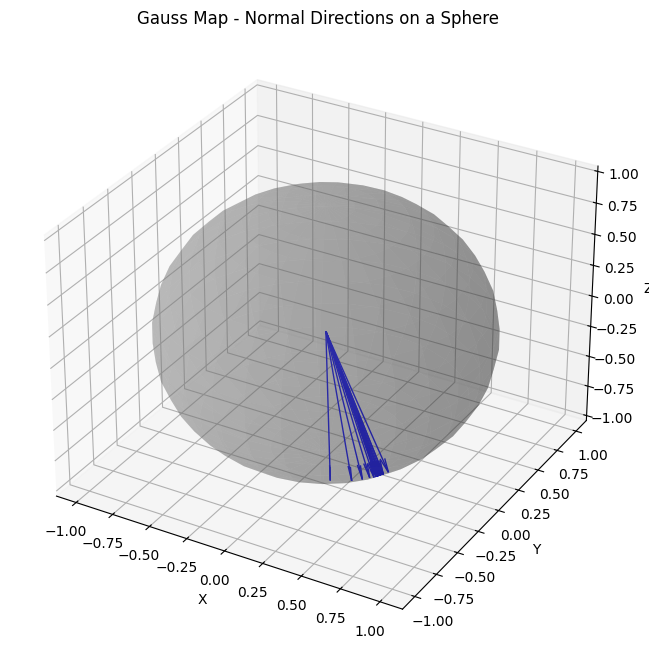

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_gauss_map_sphere(normals, title="Gauss Map - Normal Directions on a Sphere"):
    """ Visualize normal vectors on a 3D unit sphere, showing directions as arrows. """
    normals = np.array(normals)
    
    # Normalize normals to ensure they are on the unit sphere
    normals /= np.linalg.norm(normals, axis=1, keepdims=True)

    # Create a 3D figure
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the unit sphere
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 20)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='gray', alpha=0.3, edgecolor='none')  # Transparent sphere

    # Plot normal vectors as arrows
    for normal in normals:
        ax.quiver(0, 0, 0, normal[0], normal[1], normal[2], color='b', linewidth=1, arrow_length_ratio=0.1)

    # Labels & title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    plt.show()

# Run visualization on aligned normals
plot_gauss_map_sphere(aligned_neighbor_directions)




In [26]:
class GaussMapVisualizer:
    def __init__(self, centers_pcd, kdtree, plane_directions, k=20):
        self.centers_pcd = centers_pcd
        self.centers_points = np.asarray(centers_pcd.points)
        self.centers_pcd.paint_uniform_color([0.6, 0.6, 0.6])
        self.kdtree = kdtree
        self.plane_directions = plane_directions
        self.k = k

        self.current_index = 0
        self.vis = o3d.visualization.VisualizerWithKeyCallback()
        self.vis.create_window("GaussMapVisualizer")

        self.vis.register_key_callback(262, self.next_neighborhood)
        self.vis.add_geometry(self.centers_pcd)
        self._update_neighborhood()

    def get_nearest_neighbor_directions(self, point, kdtree, centers_pcd, plane_directions, k=10):
        """ Get the directions of the k nearest neighbors to a given point. """
        _, idx, _ = kdtree.search_knn_vector_3d(point, k)
        nearest_points = np.asarray(centers_pcd.points)[idx]
        nearest_directions = np.asarray(plane_directions)[idx]
        return idx, nearest_points, nearest_directions
    
    def create_normal_lines(self, neighbor_points, neighbor_directions, scale=0.2):
        """ Create line segments for the normal directions at each point. """
        line_set = o3d.geometry.LineSet()

        start_points = np.array(neighbor_points)
        end_points = start_points + scale * np.array(neighbor_directions)
        lines = [[start_points[i], end_points[i]] for i in range(len(neighbor_points))]
        line_set.points = o3d.utility.Vector3dVector(np.concatenate(lines, axis=0))
        line_indices = [[i, i + 1] for i in range(0, len(lines) * 2, 2)]
        line_set.lines = o3d.utility.Vector2iVector(line_indices)
        line_set.colors = o3d.utility.Vector3dVector(np.tile((0, 0, 1), (len(lines), 1)))
        return line_set
    
    def _update_neighborhood(self):
        """ Update visualization for the current neighborhood. """
        # Get the currently selected point
        query_point = np.asarray(self.centers_pcd.points)[self.current_index]

        # Get nearest neighbors
        idx, neighbor_points, neighbor_directions = self.get_nearest_neighbor_directions(query_point, self.kdtree, self.centers_pcd, self.plane_directions, k=self.k)

        # Extract neighbor points
        #neighbor_points = np.asarray(self.centers_pcd.points)[neighbor_indices]

        # Create a point cloud for the neighbors (red color)
        self.pcd_colors = np.tile((0.6,0.6,0.6), (self.centers_points.shape[0], 1))
        self.pcd_colors[idx] = (1, 0, 0)
        self.centers_pcd.colors = o3d.utility.Vector3dVector(self.pcd_colors)

        if hasattr(self, "normal_lines"):
            self.vis.remove_geometry(self.normal_lines)
        self.normal_lines = self.create_normal_lines(neighbor_points, neighbor_directions, scale=2)
        self.vis.add_geometry(self.normal_lines)
        view_ctl =self.vis.get_view_control()
        lookat = query_point
        zoom = 0.080000000000000002
        front = [-0.024106890455448116,-0.57254772319971181,0.81951690799604338]
        up =  [0.014828165865396817,0.81946017828866602,0.57294427451208185]
        view_ctl.set_lookat(lookat)  # Set the point the camera is looking at
        view_ctl.set_up(up)      # Set the up direction of the camera
        view_ctl.set_front(front)  # Set the front direction of the camera
        view_ctl.set_zoom(zoom)          # Set the zoom factor of the camera
        self.vis.update_geometry(self.centers_pcd)
        

        print(f"Neighborhood {self.current_index}/{len(self.centers_pcd.points)} updated")

    def next_neighborhood(self, vis):
        """ Move to the next neighborhood when right arrow key is pressed. """
        self.current_index = (self.current_index + 500) % len(self.centers_pcd.points)
        self._update_neighborhood()

    def run(self):
        """ Start the Open3D visualization loop. """
        self.vis.run()
        self.vis.destroy_window()

# Usage Example
new_kdtree, centers_pcd = build_kdtree(means)
viewer = GaussMapVisualizer(centers_pcd, new_kdtree, plane_directions, k=20)
viewer.run()
    

Neighborhood 0/52869 updated
